In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import omegaconf
import librosa
import torch
import torchaudio.functional as F
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio, display


parent = os.path.abspath(os.path.join('..'))
sys.path.append(parent)

from augmentations.augmentations import *
import augmentations.augmentations.misc as misc

from data import AudioSetViews
import models

/home/kligvasser/miniconda3/envs/audio-ssl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(spectrogram, sampling_rate, title="log-frequency power spectrogram"):
    librosa.display.specshow(spectrogram, x_axis="time", y_axis="mel", sr=sampling_rate)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def show_and_play_signal(audio, sample_rate):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
    play_signal(audio, sample_rate)


def play_signal(audio, sample_rate):
    display(Audio(audio, rate=sample_rate))


def plot_similarity_matrix(matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix.cpu().numpy(), cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Cross-Similarity Matrix')
    plt.xlabel('Set 2 Elements')
    plt.ylabel('Set 1 Elements')
    plt.show()


def read_as_melspectrogram(file_path):
    audio, sampling_rate = misc.load_audio(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram


def config_to_dict(config):
    config_dict = dict(config)

    def to_dict_saveable(value):
        if isinstance(value, np.ndarray):
            value = value.tolist()
        elif isinstance(value, omegaconf.listconfig.ListConfig):
            value = list(value)
        return value

    config_dict = {k: to_dict_saveable(v) for k, v in config_dict.items()}

    return config_dict

In [8]:
sample_rate = 8000
batch_size = 256

transforms = Compose(
    [
        RandomCropExpand(10 * sample_rate, 10 * sample_rate, pad_type="zero"),
    ]
)

train_dataset = AudioSetViews(
    df_path="/storage11/datasets/audioset/audios/balanced_train/records-hot1.pkl",
    transforms=transforms,
    sample_rate=sample_rate,
    num_views=1,
    num_repeat=1,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=16,
    shuffle=True,
)

eval_dataset = AudioSetViews(
    df_path="/storage11/datasets/audioset/audios/eval/records-hot1.pkl",
    transforms=transforms,
    sample_rate=sample_rate,
    num_views=1,
    num_repeat=1,
)
eval_loader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=batch_size,
    num_workers=16,
    shuffle=True,
)

In [11]:
config_path = "../results/simclr-audioset-vitb32/config.yaml"
model_path = "../results/simclr-audioset-vitb32/checkpoint-0100/simclr-model.pt"
device = "cuda:0"


config = omegaconf.OmegaConf.load(config_path)
# dtype = torch.float16 if config.training.mixed_precision == "fp16" else torch.float32
dtype = torch.float32
model = models.__dict__[config.model.model_name]
model = model(**config_to_dict(config.model.configuration))
model.load_state_dict(torch.load(model_path))
model = model.to(dtype).to(device)
model.eval()

ViTSimCLR(
  (spectogram): Spectrogram()
  (time_masking): TimeMasking()
  (freq_masking): FrequencyMasking()
  (backbone): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0,

In [12]:
tr_batch = next(iter(train_loader))
ev_batch = next(iter(eval_loader))

In [13]:
tr_audios = tr_batch["audio"].to(device).to(dtype)
ev_audios = ev_batch["audio"].to(device).to(dtype)

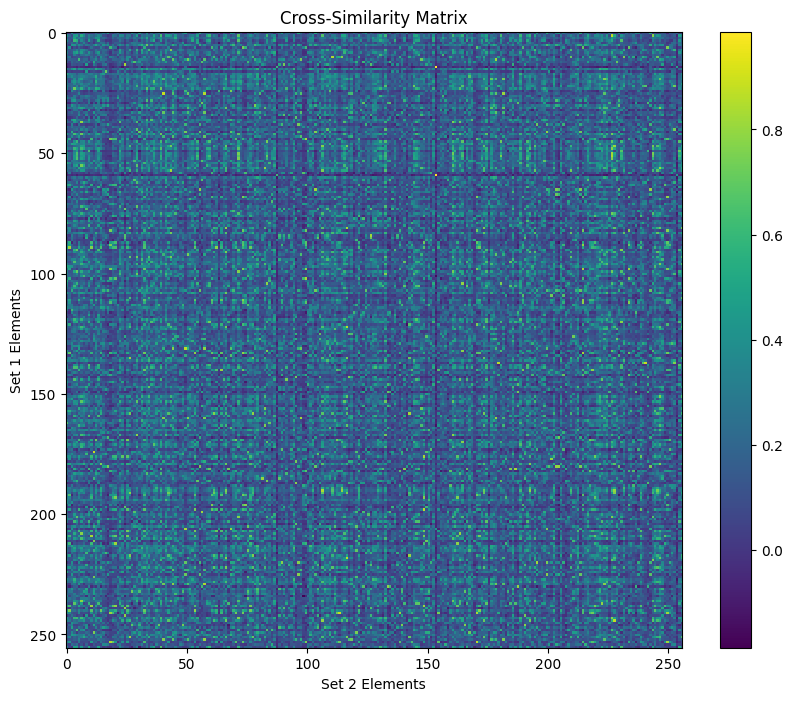

In [41]:
import torch.nn.functional as F


with torch.no_grad():
    tr_features = model.embedding(tr_audios)
    ev_features = model.embedding(ev_audios)

    tr_features = F.normalize(tr_features, dim=1)
    ev_features = F.normalize(ev_features, dim=1)

    similarity_matrix = torch.matmul(ev_features, tr_features.T)
    values, indices = torch.max(similarity_matrix, dim=0)

plot_similarity_matrix(similarity_matrix)

In [42]:
index = 27
audio = tr_audios[index].cpu()
play_signal(audio, sample_rate)
audio = ev_audios[indices[index]].cpu()
play_signal(audio, sample_rate)
values[index]

tensor(0.7246, device='cuda:0', dtype=torch.float16)